In [ ]:
from IPython.display import clear_output

!pip install -U "ray[rllib]"
!pip install tianshou
!pip install "stable-baselines3[extra]>=2.0.0a4"
!pip install mat4py

clear_output()

# LIBPackEnv

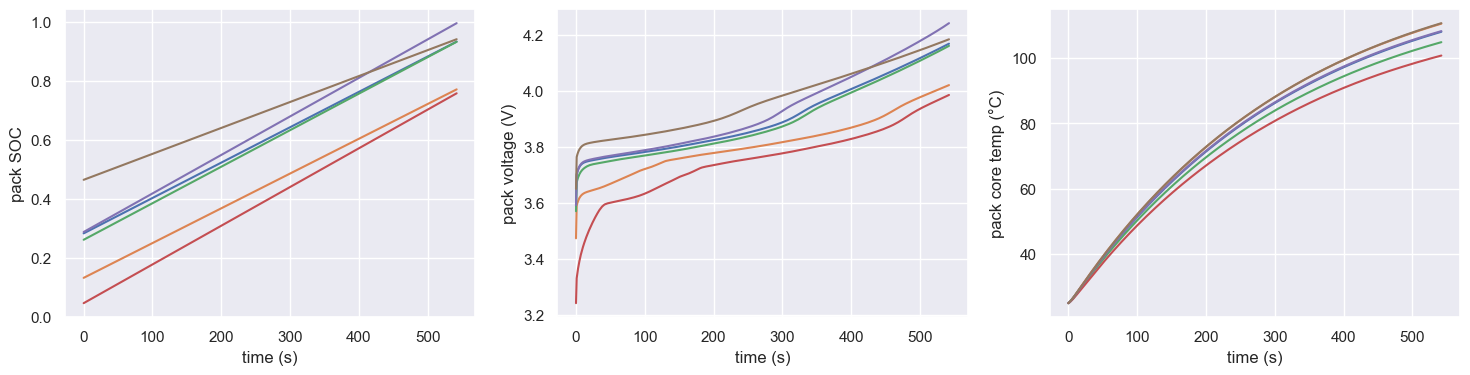

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from LIBEnv.LIB_gym import LIBPackEnv
import seaborn as sns
sns.set_theme()

env = LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1, use_switch=True)

pack_res=[]
rewards = []
pack_res.append(env.reset(0)[0].reshape(3,6))
done = False
while not done:
    next_state, reward, done, _, info = env.step(np.ones(7))
    pack_res.append(next_state.reshape(3,6))
    rewards.append(reward)

pack_res = np.array(pack_res)
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.plot(pack_res[:,0,:])
plt.xlabel('time (s)')
plt.ylabel('pack SOC')
plt.grid('on')
plt.subplot(1,3,2)
plt.plot(pack_res[:,1,:]*(env.max_voltage-env.min_voltage)+env.min_voltage)
plt.xlabel('time (s)')
plt.ylabel('pack voltage (V)')
plt.grid('on')
plt.subplot(1,3,3)
plt.plot(pack_res[:,2,:]*env.T)
plt.xlabel('time (s)')
plt.ylabel('pack core temp (°C)')
plt.grid('on')

In [4]:
env.action_space.sample()

array([0, 0, 0, 1, 0, 0, 1], dtype=int64)

### Tensorboard 

In [ ]:
#@title Tensorboard - click the refresh button once training is running

%load_ext tensorboard
%tensorboard --logdir logs

# Discrete stable baseline3

In [5]:
from stable_baselines3.common.callbacks import BaseCallback

class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq:
    :param log_dir: Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: Verbosity level: 0 for no output, 1 for info messages, 2 for debug messages
    """
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
       pass
        # Create folder if needed
        # if self.save_path is not None:
        #     os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), "timesteps")
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose >= 1:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose >= 1:
                    print(f"Saving new best model to {self.save_path}")
                  self.model.save(self.save_path)

        return True

d:\Users\amirh\anaconda3\lib\site-packages\torch\utils\tensorboard\__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [6]:
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.env_checker import check_env
import os 

timesteps = 1e7
log_dir = "./tmp/"

check_env(env, warn=True)
env = Monitor(env, log_dir+'monitor.csv', override_existing=False)

model = PPO("MlpPolicy", env, verbose=1, 
            tensorboard_log="logs", 
            learning_rate=1e-3)

# model = DQN("MlpPolicy", env, verbose=1, 
#             tensorboard_log="logs", 
#             learning_rate=1e-3, 
#             buffer_size=int(1e6),
#             batch_size=1024,
#             gamma=0.95,
#             tau=0.05,
#             policy_kwargs=dict(net_arch=[512, 512, 512]))

callback = SaveOnBestTrainingRewardCallback(check_freq=2e4, log_dir=log_dir)

# Train the agent
# model = model.load('best_model.zip', env)
model.learn(total_timesteps=timesteps, progress_bar=False) #callback=callback

Using cuda device
Wrapping the env in a DummyVecEnv.
Logging to logs\PPO_7
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.16e+03  |
|    ep_rew_mean     | -4.02e+04 |
| time/              |           |
|    fps             | 91        |
|    iterations      | 1         |
|    time_elapsed    | 22        |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.06e+03     |
|    ep_rew_mean          | -3.43e+04    |
| time/                   |              |
|    fps                  | 88           |
|    iterations           | 2            |
|    time_elapsed         | 46           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0080166655 |
|    clip_fraction        | 0.0989       |
|    clip_range           | 0.2          |
|    entropy_los

KeyboardInterrupt: 

In [ ]:
model.actor

In [ ]:
model.critic

In [ ]:
model = model.load('./best_model', env)

In [ ]:
import pandas as pd
results = pd.read_csv('./monitor.csv').reset_index()
results.columns = [results.iloc[0]]
results.drop([0], inplace=True)
returns = np.array(results['r'].astype(float)).ravel()

window = 100
rolling_mean = pd.Series(returns).rolling(window).mean()
std = pd.Series(returns).rolling(window).std()

plt.figure(figsize=(8,5))
plt.plot(returns)
plt.plot(rolling_mean, color='red', linewidth=2.5)
plt.fill_between(range(len(rolling_mean)),rolling_mean-std, rolling_mean+std, color='violet', alpha=0.5)

plt.xlabel('Episode')
plt.ylabel('Return')
plt.grid('on')

In [ ]:
import pandas as pd
results = pd.read_csv('./monitor.csv').reset_index()
results.columns = [results.iloc[0]]
results.drop([0], inplace=True)
returns = np.array(results['l'].astype(float)).ravel()

window = 100
rolling_mean = pd.Series(returns).rolling(window).mean()
std = pd.Series(returns).rolling(window).std()

plt.figure(figsize=(8,5))
plt.plot(returns)
plt.plot(rolling_mean, color='red', linewidth=2.5)
plt.fill_between(range(len(rolling_mean)),rolling_mean-std, rolling_mean+std, color='violet', alpha=0.5)

plt.xlabel('Episode')
plt.ylabel('Episode Length / Charge Duration (s)')
plt.grid('on')

In [ ]:
vec_env = model.get_env()
state = vec_env.reset()

pack_res=[]
rewards = []
actions = []

done = False
pack_res.append(state.reshape(3,6))
while not done:
    action, _states = model.predict(state, deterministic=True)
    next_state, reward, done, info = vec_env.step(action)
    state = next_state
    pack_res.append(next_state.reshape(3,6))
    rewards.append(reward)
    actions.append(action)

pack_res = np.array(pack_res)
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(pack_res[:-1,0,:])
plt.ylabel('pack SOC')
plt.grid('on')
plt.subplot(2,2,2)
plt.plot(pack_res[:-1,1,:])
plt.ylabel('pack voltage')
plt.grid('on')
plt.subplot(2,2,3)
plt.plot(pack_res[:-1,2,:])
plt.ylabel('pack core temp')
plt.grid('on')
plt.subplot(2,2,4)
plt.plot(np.array(actions)[:-1].reshape(-1,6+1)[:,:-1])
plt.plot(np.array(actions)[:-1].reshape(-1,6+1)[:,-1], "--", color='red')
plt.ylabel('current')
plt.grid('on')

In [ ]:
np.array(actions)[:-1].shape

In [ ]:
plt.plot(np.abs(pack_res[:-1,0,:] - np.mean(pack_res[:-1,0,:], axis=-1).reshape(-1,1)).sum(-1))
plt.xlabel('time')
plt.ylabel('Balance Cost')
plt.grid('on')
plt.ylim([0,0.2])

In [ ]:
plt.plot(pack_res[:-1,0,:].max(-1) - pack_res[:-1,0,:].min(-1))
plt.xlabel('time')
plt.ylabel('SOC dev')
plt.grid('on')
plt.ylim([0,0.2])

In [ ]:
np.abs(pack_res[:-1,0,:] - np.mean(pack_res[:-1,0,:], axis=-1).reshape(-1,1))

In [ ]:
np.mean(pack_res[:-1,0,:])

In [ ]:
pack_res[-2,0,:], np.std(pack_res[-2,0,:])

In [ ]:
model.save('./last_model.pth')

# Tianshu

In [ ]:
pip install tianshou

In [ ]:
import gymnasium as gym
import torch, numpy as np, torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import tianshou as ts

In [ ]:
lr, epoch, batch_size = 1e-3, 10, 64
train_num, test_num = 10, 100
gamma, n_step, target_freq = 0.9, 3, 320
buffer_size = 20000
eps_train, eps_test = 0.1, 0.05
step_per_epoch, step_per_collect = 10000, 10
logger = ts.utils.TensorboardLogger(SummaryWriter('log/dqn'))  # TensorBoard is supported!
# For other loggers: https://tianshou.readthedocs.io/en/master/tutorials/logger.html